In [1]:
import os
import torch
import shutil
import numpy as np

from PIL import Image
from tqdm import tqdm
from urllib.request import urlretrieve
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from oxford_pet import OxfordPetDataset, SimpleOxfordPetDataset, load_dataset

In [2]:
current_path =  os.path.join(os.getcwd(),"..")
data_path = os.path.join(current_path,"dataset/oxford-iiit-pet" )  # 替换为你的数据集路径
mode = "train"  # 或 "valid" 或 "test"
batch_size = 16
num_workers = 4

train_loader = load_dataset(data_path, mode, batch_size, num_workers)
valid_loader = load_dataset(data_path, "valid" , batch_size, num_workers)
test_loader = load_dataset(data_path, "test" , 1, num_workers)
# for images, labels in train_loader:
#     print(images.shape, labels.shape)

207
23
3669
torch.Size([16, 3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])


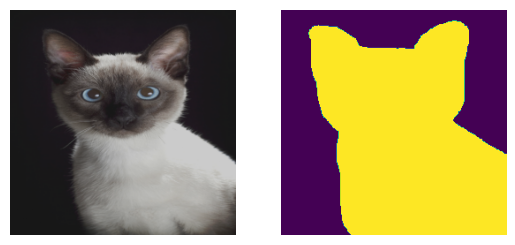

In [3]:
print(len(train_loader))
print(len(valid_loader))
print(len(test_loader))
# for images in train_loader:
#     print(images['image'].shape)

import matplotlib.pyplot as plt
import torch
i = 0
import itertools
for i, first_batch in enumerate(train_loader):
    if i == 1:
        break
    batch = first_batch['image']
    print(batch.shape)
    img = batch[1]
    print(img.shape)
    img = img.permute(1, 2, 0)

    batch1 = first_batch['mask']
    img1 = batch1[1]
    print(img1.shape)
    img1 = img1.permute(1, 2, 0)

    # 确保数据在[0, 1]范围内
    img = torch.clamp(img, 0, 1)
    fig, axs = plt.subplots(nrows=1, ncols=2)
    # 使用matplotlib绘制图像
    axs[0].imshow(img)
    axs[0].axis('off')  # 不显示坐标轴
    axs[1].imshow(img1)
    axs[1].axis('off')  # 不显示坐标轴
    plt.show()

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
import torch.nn.functional as F
import pandas as pd
from PIL import Image
from torch.utils import data
import torchvision.transforms as transforms
import os
from torch.utils.data import DataLoader
import numpy as np
from evaluate import evaluate
from inference import test
from train import train
from oxford_pet import OxfordPetDataset, SimpleOxfordPetDataset, load_dataset
from models.unet import Unet
from models.resnet34_unet import U_ResNet34

c = nn.CrossEntropyLoss()
for i, first_batch in enumerate(train_loader):
    if i == 2:
        break
    batch2 = first_batch['mask']

print(c(batch1,batch2))

tensor(-0.)


In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
Model1 = Unet().to(device)

current_path =  os.path.join(os.getcwd(),"..")
savepath_unet = os.path.join(current_path, 'saved_models', 'Unet')
hist_unet = np.load(os.path.join(savepath_unet, 'training_process.npz'))
val_acc_array = np.array(hist_unet["val_acc"])
best_epoch1 = val_acc_array.argmax()
test_model_path1 = os.path.join(savepath_unet, "{}-ep{}.pth".format("Model", best_epoch1))
checkpoint = torch.load(test_model_path1, map_location="cpu")
Model1.load_state_dict(checkpoint["state_dict"])

loss_fn = nn.CrossEntropyLoss()
lr = 1*1e-3
opt_fn = optim.Adam(Model1.parameters(), lr=lr, weight_decay=1e-4)
testloss, testacc = evaluate(Model1, test_loader, loss_fn, device)

Model1 = U_ResNet34().to(device)
savepath_resunet = os.path.join(current_path, 'saved_models', 'ResUnet')
hist_resunet = np.load(os.path.join(savepath_resunet, 'training_process.npz'))
val_acc_array = np.array(hist_resunet["val_acc"])
best_epoch2 = val_acc_array.argmax()
test_model_path2 = os.path.join(savepath_resunet, "{}-ep{}.pth".format("Model", best_epoch2))
checkpoint = torch.load(test_model_path2, map_location="cpu")
Model1.load_state_dict(checkpoint["state_dict"])
loss_fn1 = nn.CrossEntropyLoss()
lr = 1*1e-3
opt_fn1 = optim.Adam(Model1.parameters(), lr=lr, weight_decay=1e-4)
testloss_ResU, testacc_ResU = evaluate(Model1, test_loader, loss_fn1, device)
print("Unet (argmax valid ep = {}): Valid acc ={:.4f}, Train acc ={:.4f}, Test acc={:.4f}".format(best_epoch1, hist_unet["acc"][best_epoch1],hist_unet["val_acc"][best_epoch1], testacc))
print("ResUnet (argmax valid ep = {}): Valid acc ={:.4f}, Train acc ={:.4f}, Test acc={:.4f}".format(best_epoch2, hist_resunet["acc"][best_epoch2],hist_resunet["val_acc"][best_epoch2], testacc_ResU))
   


Unet (argmax valid ep = 82): Valid acc =0.9238, Train acc =0.8610, Test acc=0.8629
ResUnet (argmax valid ep = 110): Valid acc =0.9512, Train acc =0.8849, Test acc=0.8844


In [9]:
print("Unet(argmax valid ep = {}): Train acc ={:.4f}, Valid acc ={:.4f}, Test acc={:.4f}".format(best_epoch1, hist_unet["acc"][best_epoch1],hist_unet["val_acc"][best_epoch1], testacc))
 

Unet(argmax valid ep = 82): Train acc =0.9238, Valid acc =0.8610, Test acc=0.8629


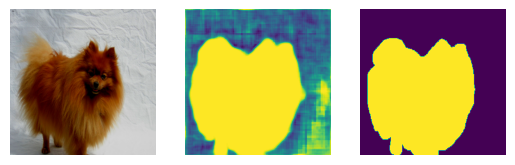

In [20]:
device = "cuda" if torch.cuda.is_available() else "cpu"
Model1 = Unet().to(device)
# val_acc_array = np.array(hist_res["val_acc"])
best_epoch1 = 149
test_model_path1 = os.path.join('/mnt/left/home/2023/angelina/DLCourse/Lab3-Binary_Semantic_Segmentation/saved_models/Unet', "{}-ep{}.pth".format("Model", best_epoch1))
checkpoint = torch.load(test_model_path1, map_location="cpu")
Model1.load_state_dict(checkpoint["state_dict"])
# evaluate(Model1, test_loader, loss_fn, device)
Model1.eval()
for i, images_dist in enumerate(train_loader):
    if i == 1:
        
        # Move data to the appropriate device (CPU or GPU)
        images = images_dist['image'][0:1,:,:,:].to(device)
        labels = images_dist['mask'][0:1,:,:,:].to(device)
        # images = images_dist['image'].to(device)
        # labels = images_dist['mask'].to(device)
        # get updated model prediction
        outputs = Model1(images)
        labels = torch.squeeze(labels, 1)
        outputs = torch.squeeze(outputs, 1)
        images = torch.squeeze(images, 0)

# print(images.shape)

images = images.permute(1, 2, 0).cpu().numpy()
outputs = outputs.permute(1, 2, 0).detach().cpu().numpy()
labels = labels.permute(1, 2, 0).cpu().numpy()

# img = torch.clamp(img, 0, 1)
# fig, axs = plt.subplots(nrows=1, ncols=2)
# 使用matplotlib绘制图像
fig, axs = plt.subplots(nrows=1, ncols=3)
axs[0].imshow(images)
axs[0].axis('off')  # 不显示坐标轴
axs[1].imshow(outputs)
axs[1].axis('off')  # 不显示坐标轴
axs[2].imshow(labels)
axs[2].axis('off')  # 不显示坐标轴
plt.show()
    # Calc updated loss
    # loss = loss_fn(outputs, labels)
    
    # running_loss += loss.item()
    # dice_score_batch = dice_score(outputs, labels)
    # dice_scores.append(dice_score_batch.item())

    # del images, labels, outputs, loss, dice_score_batch
    # torch.cuda.empty_cache()

In [ ]:

batch = first_batch['image']
print(batch.shape)
img = batch[1]
print(img.shape)
img = img.permute(1, 2, 0)

batch1 = first_batch['mask']
img1 = batch1[1]
print(img1.shape)
img1 = img1.permute(1, 2, 0)

# 确保数据在[0, 1]范围内
img = torch.clamp(img, 0, 1)
fig, axs = plt.subplots(nrows=1, ncols=2)
# 使用matplotlib绘制图像
axs[0].imshow(img)
axs[0].axis('off')  # 不显示坐标轴
axs[1].imshow(img1)
axs[1].axis('off')  # 不显示坐标轴
plt.show()
print(testloss, testacc)
# print("ResNet50 (argmax valid): Train acc ={:.4f}, Train acc ={:.4f}, Test acc={:.4f}".format(hist_res["acc"][best_epoch1],hist_res["val_acc"][best_epoch1], testacc))
# opt_fn1 = optim.Adam(Model2.parameters(), lr=lr, weight_decay=1e-4)
# testloss1, testacc1 = evaluate(Model2, TestData, loss_fn, opt_fn1, device)
# print("VGG19 (argmax valid): Train acc ={:.4f}, Train acc ={:.4f}, Test acc={:.4f}".format(hist_vgg["acc"][best_epoch2],hist_vgg["val_acc"][best_epoch2], testacc1))


In [22]:
current_path =  os.path.join(os.getcwd(),"..")
savepath_unet = os.path.join(current_path, 'saved_models', 'Unet')
hist_unet = np.load(os.path.join(savepath_unet, 'training_process.npz'))
savepath_resunet = os.path.join(current_path, 'saved_models', 'ResUnet')
hist_resunet = np.load(os.path.join(savepath_resunet, 'training_process.npz'))

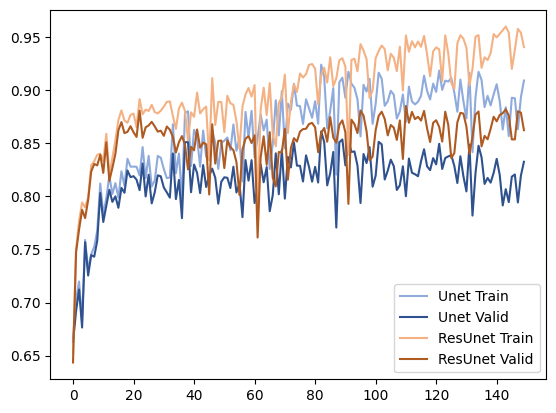

In [29]:
fig
plt.plot(hist_unet['acc'], color = (143/255,170/255,220/255), label = 'Unet Train')
plt.plot(hist_unet['val_acc'],color = (47/255,82/255,143/255), label = 'Unet Valid')
plt.plot(hist_resunet['acc'], color = (244/255,177/255,131/255), label = 'ResUnet Train')
plt.plot(hist_resunet['val_acc'], color = (174/255,90/255,33/255), label = 'ResUnet Valid')
plt.legend()
plt.show()